Tests for BM25 Functions found [here](http://www.minerazzi.com/tutorials/okapi-bm25-model.pdf)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math



#Best Match Components

#IF term
#freq: frequency in the document
#k: smoothing constant
def ifterm(freq, k):
    localweight = freq/(k+freq)
    return localweight

#IDF term
#numDocs: int # of documents in the collection
#docsWTerm: int # of documents with the term

def idfterm(numDocs, docsWTerm):
    try:
        globalweight = math.log((numDocs-docsWTerm)/docsWTerm)
        return globalweight
    except:
        return 0

    
#idf term with l variable for lift
#l>1 avoids all neg weights
def idfwithlift(numDocs, docsWTerm, l):
    try:
        globalweight = math.log(((numDocs-docsWTerm)/docsWTerm)+l)
        return globalweight
    except:
        return 0 
    
#Final weight calculation
def weight(numDocs, docsWTerm, freq, k):
    weight = ifterm(freq,k)*idfterm(numDocs,docsWTerm)
    return weight



The functions above compute the if and idf terms for if-idf searching

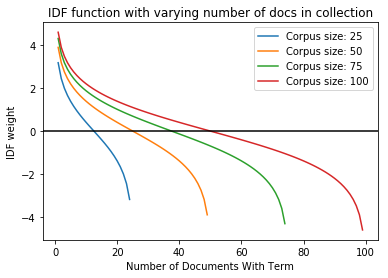

In [3]:
#Testing simplest form of  idf term

#graphs different possible frequencies based on range of occurences
def graphIDF(occur, freq,idfterm):
    xvals = range(1,freq)
    yvals = list()
    for x in xvals:
        yvals.append(idfterm(occur,x))
    plt.plot(xvals,yvals, label= "Corpus size: "+str(occur))    
for x in range(25,125,25):
    graphIDF(x,x,idfterm)
plt.xlabel('Number of Documents With Term')
plt.ylabel('IDF weight')
plt.title('IDF function with varying number of docs in collection')
plt.legend()
plt.axhline(0, color='black')
plt.show()



As the corpus size increases, a rare term, a term with a low number of documents containing this term, has a high weight. This weight value falls off slower as the corpus size increases. One could determine "keywords" of a passage by picking the top terms with a high IDF weight. That would indicate that this word is rare in the corpus.

This function can be used to get rid of the extraneous terms such as "the", "and", "a", ect, in order to have a more precise query.

In implementation, this "rarity" factor is an important factor in longer query and should be weighted higher when the search query is longer.

Also note that if the word is mentioned in more than half the articles, it obtains a negative weight. This value should either be floored at 0 or adjusted for with an offset. A document should not be penalized for containing frequently used terms.

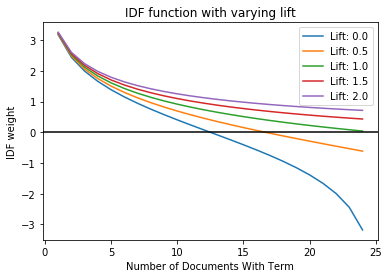

In [4]:
#testing different lift values for the IDF term
def graphIDF(occur, freq,l):
    xvals = range(1,freq)
    yvals = list()
    for x in xvals:
        yvals.append(idfwithlift(occur,x,l))
    plt.plot(xvals,yvals, label= "Lift: "+str(l))    
for x in range(0,25,5):
    graphIDF(25,25,x/10)

plt.xlabel('Number of Documents With Term')
plt.ylabel('IDF weight')
plt.title('IDF function with varying lift')
plt.legend()
plt.axhline(0, color='black')
plt.show()

These graphs show the importance of having lift in the query. ES uses a lift of 1.0 as its default avoiding any negative scoring.

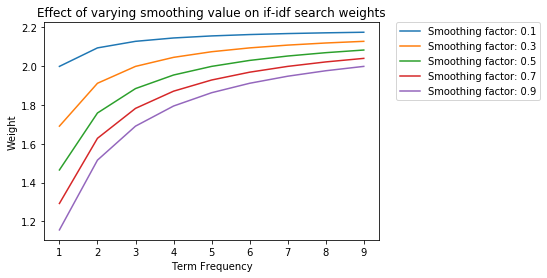

In [5]:
#Testing different k-values (smoothness constant)

def graphTFIDF(numDocs, docsWTerm, freq, k):
    xvals = range(1,freq)
    yvals = list()
    for x in xvals:
        yvals.append(weight(numDocs,docsWTerm,x, k))
    plt.plot(xvals,yvals, label = "Smoothing factor: "+str(k))
    
for k in range(1,10,2):
    graphTFIDF(100, 10, 10, k/10)
plt.xlabel('Term Frequency')
plt.ylabel('Weight')
plt.title('Effect of varying smoothing value on if-idf search weights')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

plt.show()

This plot shows how the changing of the "smoothness factor", k, changes the weighting of different frequencies. As the smooting factor increases, the weight of the first term found decreases. 

A higher k factor should be used for longer documents because the first discovery of a word has less weight. With a low k value, any mention of a certain topic leads to a high weight. Furthermore, because of this high weight given to the initial discovery of a word, the subsequent mentions hold much less value. 

An increase in the smoothness constant causes later saturation of the weight and puts less value on the term only being mentioned once. The most commong smoothing factor used is .5.

In [6]:
#Verbose vs Scope Hypotheses
#Updating the TF term to accomodate for size


#calculates dlave: avg doc length in corpus from list of doc lengths
def dlAve(docs):
    docLens = list()
    for doc in docs:
        docLens.append(len(doc))
    arr = np.asarray(docLens)
    return np.mean(arr)#vectorized average function (faster!!)

#Calculates BM25 local weight term
#freq: freq of term i in doc
#kl: smoothing param for term frequencies
#b: param for length normalization
#dlj: length of doc
#dlave: avg doc length in corpus
def BM25lwterm(freq, kl, b, dlj, dlave):
    num = freq*(kl+1)
    den = (1-b)+b*(dlj/dlave)
    den = (kl*den)+freq
    return num/den

#Docs is a list of strings of searching docs
#items in docs have words seperated by spaces
#query has query seperated by commas
#returns map of docs with the term to weight
def BM25(docs, query, weights, k=.5, k_l=1.2, b=.6):
    numDocs = len(docs)
    docsWithTerm = list()
    docToWeight = dict()
    docLens = list()
    queryTerms = query.split(",")
    qDict = queryDict(queryTerms,weights)
    termToIDF = dict()
    for x in queryTerms:
        termToIDF[x] = 0
    dlave = dlAve(docs)
    for doc in docs:
        docLens.append(len(doc))
        for x in queryTerms:
            docToWeight[doc]=0
            if x in doc.split(" "):
                termToIDF[x] +=1
                docsWithTerm.append(doc)
                break
    for x in queryTerms:
        termToIDF[x] = idfterm(numDocs,termToIDF[x])
    #Global weight calculation:
    for doc in docsWithTerm:
        docToWeight[doc] = BM25Doc(termToIDF,doc,qDict,k_l,b,dlave)
    return docToWeight
        
    
#Creates a dictionary between the weights and terms
def queryDict(queryTerms,weights):
    qDict = dict()
    for i in range(0,len(queryTerms)):
        w = weights[i]
        term = queryTerms[i]
        qDict[term] = w 
    return qDict
    

     
#finds the single doc's weight value
#doc: string of words separated by " "
#query: list of query terms
#TODO: implement with query as map to weights
def BM25Doc(termToIDF,doc,query,k_1,b,dlave):
    docweight=0
    for x in query.keys():
        d = doc.split(" ")
        weight = 0
        if x in d:
            weight = termToIDF[x]
            #count frequency
            freq = d.count(x)
            l = len(d)
            weight *= BM25lwterm(freq,.5,b,l, dlave)
        
        #adjustment based on given weight
        docweight+=query[x]*weight

    return docweight


      



Typical values of constant variables k,b,and kl are:

k=.5 (smoothing constat for IF term, see graph above)

.5<b<.8 (length normalization parameter)
    Elastic Search uses a .75 value for b. This value increases the amount that doc length is factored out. Therefore it is emphasizing the verbose hypothesis.

1.2<kl<2 (smoothing param for adjusting term frequencies)
    k1 is set to 1.2 in ES



In [7]:
#Tester
import string
#import test documents and parse into list of strings
file = open("news_test.txt","r")
docs= file.readlines()
trans = str.maketrans('', '', string.punctuation)
cleanDocs= list()
for doc in docs:
    cleanDocs.append(doc.translate(trans).rstrip().lower())
#prompt for query



outDict = BM25(cleanDocs,"adventure,armistice,korea,leadership",[0,.5,1,1])

#sort by values
#[(k, outDict[k]) for k in sorted(outDict, key=outDict.get, reverse=True)][:1]


